In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram

sns.set_style("white")
sns.set_context('notebook')

Using TensorFlow backend.


In [4]:
training_data = pd.read_pickle('../data/training_data.pkl')

In [5]:
training_data.groupby('call').size()

call
a    14589
f     1600
g     4309
s    21156
dtype: int64

In [6]:
# Get Labels
Y = pd.get_dummies(training_data.call).astype(float).values
# Get training data as numpy array
X = training_data.drop('call', axis=1).astype(float).values

In [7]:
X.shape

(41654, 71)

In [8]:
Y.shape

(41654, 4)

In [9]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [10]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=71, kernel_initializer='normal', activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)

In [12]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [13]:
if not os.path.exists('../data/deep_learning/multiclass_relu_probs.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/multiclass_relu_probs.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/multiclass_relu_probs.npy')

Epoch 1/10
37488/37488 [==============================] - 35s - loss: 0.6735 - acc: 0.7247    
Epoch 2/10
37488/37488 [==============================] - 34s - loss: 0.5562 - acc: 0.7835    
Epoch 3/10
37488/37488 [==============================] - 30s - loss: 0.5295 - acc: 0.7933    
Epoch 4/10
37488/37488 [==============================] - 30s - loss: 0.5121 - acc: 0.7990    
Epoch 5/10
37488/37488 [==============================] - ETA: 0s - loss: 0.5029 - acc: 0.803 - 34s - loss: 0.5029 - acc: 0.8030    
Epoch 6/10
37488/37488 [==============================] - 30s - loss: 0.4941 - acc: 0.8051    
Epoch 7/10
37488/37488 [==============================] - 32s - loss: 0.4855 - acc: 0.8100    
Epoch 8/10
37488/37488 [==============================] - 33s - loss: 0.4807 - acc: 0.8119    
Epoch 9/10
37488/37488 [==============================] - 31s - loss: 0.4757 - acc: 0.8111    
Epoch 10/10
37488/37488 [==============================] - 31s - loss: 0.6746 - acc: 0.7251    
Epoch 2/10


37489/37489 [==============================] - 31s - loss: 0.5547 - acc: 0.7805    
Epoch 3/10
37489/37489 [==============================] - 32s - loss: 0.5295 - acc: 0.7922    
Epoch 4/10
37489/37489 [==============================] - 31s - loss: 0.5149 - acc: 0.7973    
Epoch 5/10
37489/37489 [==============================] - 32s - loss: 0.5034 - acc: 0.8008    
Epoch 6/10
37489/37489 [==============================] - 31s - loss: 0.4934 - acc: 0.8063    
Epoch 7/10
37489/37489 [==============================] - 33s - loss: 0.4892 - acc: 0.8073    
Epoch 8/10
37489/37489 [==============================] - 34s - loss: 0.4824 - acc: 0.8093    
Epoch 9/10
37489/37489 [==============================] - 33s - loss: 0.4761 - acc: 0.8121    
Epoch 10/10
37489/37489 [==============================] - 38s - loss: 0.6857 - acc: 0.7151    
Epoch 2/10
37489/37489 [==============================] - 39s - loss: 0.5609 - acc: 0.7794    
Epoch 3/10
37489/37489 [==============================] - 39

In [14]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [15]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [16]:
metrics.accuracy_score(Y, predicted_transformed)

0.80642915446295671

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = germline
* 3 = somatic

In [17]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.80      0.74      0.77     14589
          1       0.56      0.47      0.51      1600
          2       0.70      0.73      0.71      4309
          3       0.85      0.89      0.87     21156

avg / total       0.80      0.81      0.80     41654



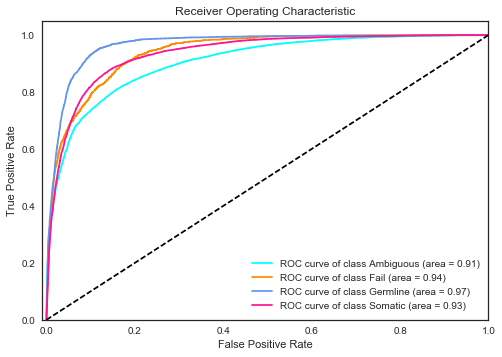

In [18]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Germline', 3: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00040597  0.00343494  0.00447062  0.0064856   0.00769449  0.00790297
  0.00789482  0.00704294  0.0049625   0.00168334]


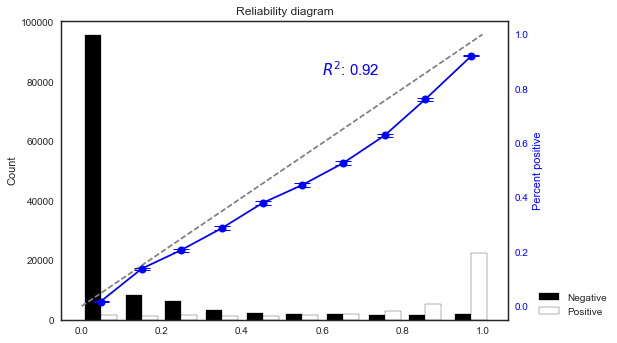

In [19]:
create_reliability_diagram(probabilities, Y, 
                           ['Ambiguous','Fail','Germline', 'Somatic'], 'blue')

## Refactor to single class classifier 
Manual reviewer's calling variants germline is problematic as the callers that produced the calls are designed to call somatic variants. These germline calls are likely very poor quality and in most analysis streams get thrown out anyway. While 'ambigous' variant exist in a grey area where the reviewer is unsure whether to call the variant somatic or fail. All of these classes (germile, ambiguous, and fail) are treated the same in downstream analysis (thrown out).

In [20]:
training_data.groupby('call').size()

call
a    14589
f     1600
g     4309
s    21156
dtype: int64

In [21]:
training_data['binary_call'] = training_data.call.replace(['a', 'f', 'g'], False)
training_data['binary_call'] = training_data['binary_call'].replace('s', True)

In [22]:
training_data.groupby('binary_call').size()

binary_call
False    20498
True     21156
dtype: int64

In [23]:
# Get Labels
binary_Y = training_data.binary_call.astype(int).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [24]:
X.shape

(41654, 71)

In [25]:
binary_Y.shape

(41654,)

In [26]:
# define baseline model
def baseline_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=71, kernel_initializer='normal', activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
binary_estimator = KerasClassifier(build_fn=baseline_binary_model, epochs=10, batch_size=5, verbose=1)

In [28]:
binary_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [29]:
if not os.path.exists('../data/deep_learning/binary_relu_probs.npy'):
    binary_probabilities = cross_val_predict(binary_estimator, X, binary_Y, cv=binary_kfold, method='predict_proba')
    np.save('../data/deep_learning/binary_relu_probs.npy', probabilities)
else:
    binary_probabilities = np.load('../data/deep_learning/binary_relu_probs.npy')

Epoch 1/10
37488/37488 [==============================] - 32s - loss: 0.4072 - acc: 0.8213    
Epoch 2/10
37488/37488 [==============================] - 34s - loss: 0.3525 - acc: 0.8502    
Epoch 3/10
37488/37488 [==============================] - 37s - loss: 0.3380 - acc: 0.8585    
Epoch 4/10
37488/37488 [==============================] - 36s - loss: 0.3280 - acc: 0.8640    
Epoch 5/10
37488/37488 [==============================] - 38s - loss: 0.3212 - acc: 0.8662    
Epoch 6/10
37488/37488 [==============================] - 38s - loss: 0.3159 - acc: 0.8691    
Epoch 7/10
37488/37488 [==============================] - 35s - loss: 0.3120 - acc: 0.8709    
Epoch 8/10
37488/37488 [==============================] - ETA: 0s - loss: 0.3080 - acc: 0.871 - 33s - loss: 0.3080 - acc: 0.8715    
Epoch 9/10
37488/37488 [==============================] - 37s - loss: 0.3059 - acc: 0.8723    
Epoch 10/10
37488/37488 [==============================] - 38s - loss: 0.4100 - acc: 0.8203    
Epoch 2/10


37489/37489 [==============================] - ETA: 0s - loss: 0.3509 - acc: 0.853 - 33s - loss: 0.3508 - acc: 0.8531    
Epoch 3/10
37489/37489 [==============================] - 32s - loss: 0.3367 - acc: 0.8592    
Epoch 4/10
37489/37489 [==============================] - 33s - loss: 0.3275 - acc: 0.8639    
Epoch 5/10
37489/37489 [==============================] - 32s - loss: 0.3205 - acc: 0.8658    
Epoch 6/10
37489/37489 [==============================] - 34s - loss: 0.3146 - acc: 0.8689    
Epoch 7/10
37489/37489 [==============================] - 34s - loss: 0.3108 - acc: 0.8695    
Epoch 8/10
37489/37489 [==============================] - 38s - loss: 0.3068 - acc: 0.8721    
Epoch 9/10
37489/37489 [==============================] - 39s - loss: 0.3036 - acc: 0.8731    
Epoch 10/10
37489/37489 [==============================] - 39s - loss: 0.4060 - acc: 0.8221    
Epoch 2/10
37489/37489 [==============================] - 38s - loss: 0.3530 - acc: 0.8536    
Epoch 3/10
37489/37489

In [30]:
predicted = np.array([list(a).index(max(list(a))) for a in list(binary_probabilities)])

In [31]:
metrics.accuracy_score(binary_Y, predicted)

0.86966437797090312

In [32]:
print(metrics.classification_report(binary_Y, predicted))

             precision    recall  f1-score   support

          0       0.87      0.87      0.87     20498
          1       0.87      0.87      0.87     21156

avg / total       0.87      0.87      0.87     41654



In [33]:
somatic_prob = binary_probabilities[:,1]

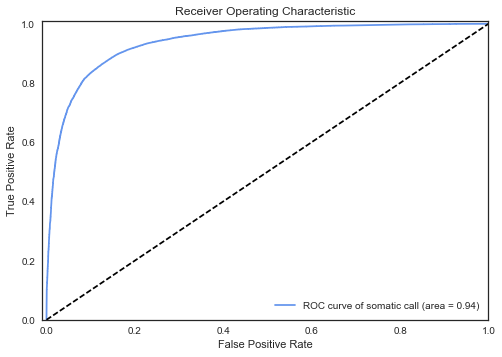

In [34]:
plt.title('Receiver Operating Characteristic')
fpr, tpr, _ = metrics.roc_curve(binary_Y, somatic_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='cornflowerblue',label='ROC curve of somatic call'
         ' (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.0010982   0.00412058  0.00539447  0.0078439   0.00936455  0.00964912
  0.00972062  0.00932304  0.0059132   0.00134771]


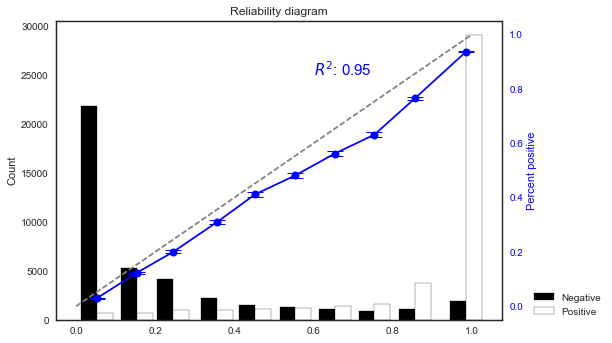

In [35]:
create_reliability_diagram(binary_probabilities, np.array([np.logical_not(binary_Y),binary_Y]).T,['Fail', 'Somatic'], 'blue')

## Elu activation function

In [36]:
# define baseline model
def baseline_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=71, kernel_initializer='normal', activation='elu'))
    model.add(Dense(23, activation='elu'))
    model.add(Dense(23, activation='elu'))
    model.add(Dense(2, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [37]:
binary_estimator = KerasClassifier(build_fn=baseline_binary_model, epochs=10, batch_size=5, verbose=1)

In [38]:
binary_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [39]:
if not os.path.exists('../data/deep_learning/binary_elu_probs.npy'):
    binary_probabilities = cross_val_predict(binary_estimator, X, binary_Y, cv=binary_kfold, method='predict_proba')
    np.save('../data/deep_learning/binary_elu_probs.npy', probabilities)
else:
    binary_probabilities = np.load('../data/deep_learning/binary_elu_probs.npy')

Epoch 1/10
37488/37488 [==============================] - 34s - loss: 0.4340 - acc: 0.8076    
Epoch 2/10
37488/37488 [==============================] - 35s - loss: 0.3711 - acc: 0.8422    
Epoch 3/10
37488/37488 [==============================] - 36s - loss: 0.3571 - acc: 0.8497    
Epoch 4/10
37488/37488 [==============================] - 39s - loss: 0.3467 - acc: 0.8533    
Epoch 5/10
37488/37488 [==============================] - 39s - loss: 0.3385 - acc: 0.8566    
Epoch 6/10
37488/37488 [==============================] - 40s - loss: 0.3320 - acc: 0.8589    
Epoch 7/10
37488/37488 [==============================] - 40s - loss: 0.3256 - acc: 0.8626    
Epoch 8/10
37488/37488 [==============================] - 40s - loss: 0.3205 - acc: 0.8643    
Epoch 9/10
37488/37488 [==============================] - 41s - loss: 0.3162 - acc: 0.8659    
Epoch 10/10
37488/37488 [==============================] - 44s - loss: 0.4312 - acc: 0.8106    
Epoch 2/10
37488/37488 [=========================

37489/37489 [==============================] - 31s - loss: 0.3775 - acc: 0.8388    
Epoch 3/10
37489/37489 [==============================] - 36s - loss: 0.3560 - acc: 0.8492    
Epoch 4/10
37489/37489 [==============================] - 37s - loss: 0.3431 - acc: 0.8543    
Epoch 5/10
37489/37489 [==============================] - 30s - loss: 0.3340 - acc: 0.8580    
Epoch 6/10
37489/37489 [==============================] - 30s - loss: 0.3267 - acc: 0.8625    
Epoch 7/10
37489/37489 [==============================] - 35s - loss: 0.3220 - acc: 0.8645    
Epoch 8/10
37489/37489 [==============================] - 30s - loss: 0.3158 - acc: 0.8655    
Epoch 9/10
37489/37489 [==============================] - 31s - loss: 0.3135 - acc: 0.8681    
Epoch 10/10
37489/37489 [==============================] - 30s - loss: 0.4349 - acc: 0.8075    
Epoch 2/10
37489/37489 [==============================] - 30s - loss: 0.3710 - acc: 0.8434    
Epoch 3/10
37489/37489 [==============================] - 30

In [40]:
predicted = np.array([list(a).index(max(list(a))) for a in list(binary_probabilities)])

In [41]:
metrics.accuracy_score(binary_Y, predicted)

0.86692754597397614

In [42]:
print(metrics.classification_report(binary_Y, predicted))

             precision    recall  f1-score   support

          0       0.86      0.87      0.87     20498
          1       0.87      0.87      0.87     21156

avg / total       0.87      0.87      0.87     41654



In [43]:
somatic_prob = binary_probabilities[:,1]

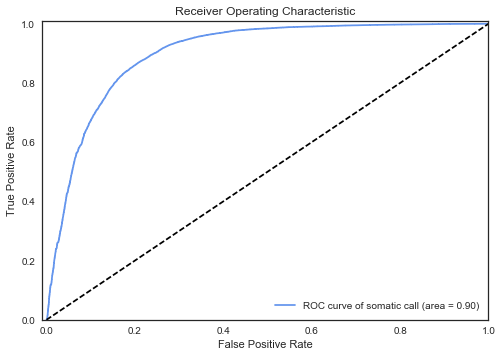

In [44]:
plt.title('Receiver Operating Characteristic')
fpr, tpr, _ = metrics.roc_curve(binary_Y, somatic_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='cornflowerblue',label='ROC curve of somatic call'
         ' (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00127569  0.00508068  0.00805559  0.00858358  0.00925333  0.00808689
  0.00777566  0.0064195   0.00452378  0.00190823]


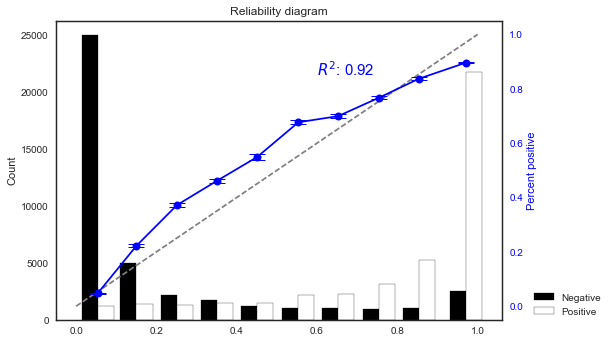

In [45]:

create_reliability_diagram(binary_probabilities, np.array([np.logical_not(binary_Y),binary_Y]).T,['Fail', 'Somatic'], 'blue')

# Somatic, ambigous, fail classifier

In [46]:
three_class = training_data.replace('g','f')

In [47]:
three_class.groupby('call').size()

call
a    14589
f     5909
s    21156
dtype: int64

In [48]:
# Get Labels
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [49]:
X.shape

(41654, 71)

In [50]:
Y.shape

(41654, 3)

In [51]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [52]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(67, input_dim=71, kernel_initializer='normal', activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(23, activation='relu'))
    model.add(Dense(3, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [53]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)

In [54]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [55]:
if not os.path.exists('../data/deep_learning/threeclass_relu_probs.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/threeclass_relu_probs.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/threeclass_relu_probs.npy')

Epoch 1/10
37488/37488 [==============================] - 32s - loss: 0.6022 - acc: 0.7415    
Epoch 2/10
37488/37488 [==============================] - 32s - loss: 0.5046 - acc: 0.7966    
Epoch 3/10
37488/37488 [==============================] - 33s - loss: 0.4820 - acc: 0.8049    
Epoch 4/10
37488/37488 [==============================] - 32s - loss: 0.4672 - acc: 0.8099    
Epoch 5/10
37488/37488 [==============================] - 32s - loss: 0.4602 - acc: 0.8131    
Epoch 6/10
37488/37488 [==============================] - 33s - loss: 0.4530 - acc: 0.8164    
Epoch 7/10
37488/37488 [==============================] - 32s - loss: 0.4469 - acc: 0.8180    
Epoch 8/10
37488/37488 [==============================] - 33s - loss: 0.4419 - acc: 0.8202    
Epoch 9/10
37488/37488 [==============================] - 34s - loss: 0.4371 - acc: 0.8214    
Epoch 10/10
37488/37488 [==============================] - 34s - loss: 0.6075 - acc: 0.7386    
Epoch 2/10
37488/37488 [=========================

37489/37489 [==============================] - 34s - loss: 0.5040 - acc: 0.7960    
Epoch 3/10
37489/37489 [==============================] - 35s - loss: 0.4823 - acc: 0.8051    
Epoch 4/10
37489/37489 [==============================] - 35s - loss: 0.4688 - acc: 0.8099    
Epoch 5/10
37489/37489 [==============================] - 34s - loss: 0.4588 - acc: 0.8136    
Epoch 6/10
37489/37489 [==============================] - 35s - loss: 0.4503 - acc: 0.8161    
Epoch 7/10
37489/37489 [==============================] - 34s - loss: 0.4458 - acc: 0.8175    
Epoch 8/10
37489/37489 [==============================] - 35s - loss: 0.4399 - acc: 0.8210    
Epoch 9/10
37489/37489 [==============================] - 35s - loss: 0.4354 - acc: 0.8219    
Epoch 10/10
37489/37489 [==============================] - 34s - loss: 0.5856 - acc: 0.7522    
Epoch 2/10
37489/37489 [==============================] - 33s - loss: 0.5006 - acc: 0.7974    
Epoch 3/10
37489/37489 [==============================] - 34

In [56]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [57]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [58]:
metrics.accuracy_score(Y, predicted_transformed)

0.81591203725932682

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = germline
* 3 = somatic

In [59]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.81      0.73      0.77     14589
          1       0.70      0.75      0.73      5909
          2       0.85      0.89      0.87     21156

avg / total       0.82      0.82      0.81     41654



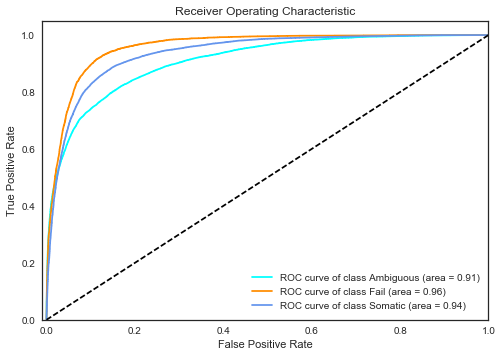

In [60]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00059922  0.00355891  0.00484212  0.00619793  0.00780359  0.00789745
  0.0084122   0.00745796  0.00514406  0.001602  ]


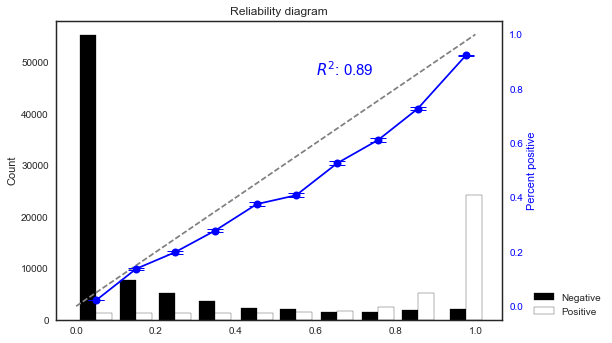

In [61]:
create_reliability_diagram(probabilities, Y,['Ambiguous','Fail','Somatic'], 'blue')

* elu model
* drop amb
* som/amb/fail model
* different roc curves for each class
* look at signal for miscalls
* ambig analysis
* run on filtered variants one study
* variant callers roc curve
* trained model feature analyasis top ten feature
* new model -- reviewer variability - shuffel all reviewers and classify model